In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

image_dir = "/content/drive/MyDrive/Dataset/images"
mask_dir = "/content/drive/MyDrive/Dataset/masques"


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [3]:
!pip uninstall segmentation-models-pytorch
!pip install segmentation-models-pytorch==0.2.0,

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 13.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12403 sha256=5c51d04dc4115a3864aa700ed0ce1918530d4a5cded22ecb3d55a55ca3e22a75
  Stored in directory: /root/.cache/pip/wheels/61/3a/b0/0b4c443c380bd934701b0a25e4aed76479e4fcaf1a6f955664
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=efe4c5bdaa689a48042374f254f2de8a2e1f76cd7320ad39803e8ad76fad1e2e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing installation

In [8]:
# 1️⃣ Importer les bibliothèques nécessaires
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from segmentation_models_pytorch import DeepLabV3Plus


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")

image_dir = "/content/drive/MyDrive/Dataset/images"
mask_dir = "/content/drive/MyDrive/Dataset/masques"

# 2️⃣ Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # Charge l'image et le masque
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = transforms.Resize((64, 64))(mask)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Prépare les données
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# 3️⃣ Charge le modèle complet
weights_path = "/content/best_model.pth"
model = torch.load(weights_path, map_location=device)
model.to(device)
print("Modèle complet chargé avec succès ✅")

# 4️⃣ Modifie la tête de segmentation pour une tâche binaire
model.segmentation_head = nn.Conv2d(256, 1, kernel_size=(1, 1))  # Nouvelle tête avec 1 classe
model.to(device)
print("Tête de segmentation modifiée pour 1 classe ✅")

# 5️⃣ Gele toutes les couches sauf la tête
for param in model.parameters():
    param.requires_grad = False
for param in model.segmentation_head.parameters():
    param.requires_grad = True

# 6️⃣ Configure la fonction de perte et l'optimiseur
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.segmentation_head.parameters(), lr=0.0001)



Device utilisé : cpu
Modèle complet chargé avec succès ✅
Tête de segmentation modifiée pour 1 classe ✅


<ipython-input-8-b32bc7fd4b42>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(weights_path, map_location=device)


In [ ]:
# 7️⃣ Boucle d'entraînement
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Époque {epoch+1}/{num_epochs}, Perte moyenne: {running_loss/len(train_loader):.4f}")

# 8️⃣ Sauvegarde du modèle fine-tuné
torch.save(model, "/content/drive/MyDrive/deeplabv3plus_finetuned_binaire.pth")
print("Modèle fine-tuné sauvegardé avec succès ✅")

In [9]:
for images, masks in train_loader:
    images, masks = images.to(device), masks.to(device)

    outputs = model(images)
    print(f"Forme des images : {images.shape}")
    print(f"Forme des masques : {masks.shape}")
    print(f"Forme des sorties : {outputs.shape}")
    break

Forme des images : torch.Size([4, 3, 256, 256])
Forme des masques : torch.Size([4, 1, 64, 64])
Forme des sorties : torch.Size([4, 1, 64, 64])


In [10]:
test_image_dir = "/content/drive/MyDrive/Dataset/test_images"
test_mask_dir = "/content/drive/MyDrive/Dataset/test_masks"

# Dataset pour les données de test
test_dataset = SegmentationDataset(test_image_dir, test_mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Nombre d'images dans le jeu de test : {len(test_dataset)}")

Nombre d'images dans le jeu de test : 22


In [11]:
def iou_score(preds, targets):
    preds = (torch.sigmoid(preds) > 0.5).float()  # Seulement les pixels > 0.5
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection / union).item() if union > 0 else 0

# Évaluation sur le jeu de test
model.eval()
test_iou = 0.0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        # Redimensionne les prédictions pour correspondre à la taille des masques
        outputs = nn.functional.interpolate(outputs, size=(masks.shape[2], masks.shape[3]), mode="bilinear", align_corners=False)

        # Calcule l'IoU
        test_iou += iou_score(outputs, masks)

# Moyenne des IoU
test_iou /= len(test_loader)
print(f"IoU moyen sur le jeu de test : {test_iou:.4f}")

IoU moyen sur le jeu de test : 0.1368


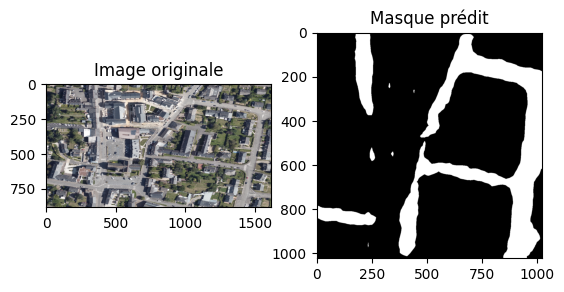

In [75]:
from PIL import Image
import matplotlib.pyplot as plt

test_image_path = "/content/drive/MyDrive/Dataset/test_images/image_010.png"
image = Image.open(test_image_path).convert("RGB")

input_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = input_transform(image).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    output = model(image_tensor)
    prediction = nn.functional.interpolate(output, size=(1024, 1024), mode="bilinear", align_corners=False)
    prediction = (torch.sigmoid(prediction) > 0.5).float().squeeze().cpu().numpy()


plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image originale")

plt.subplot(1, 2, 2)
plt.imshow(prediction, cmap="gray")
plt.title("Masque prédit")
plt.show()

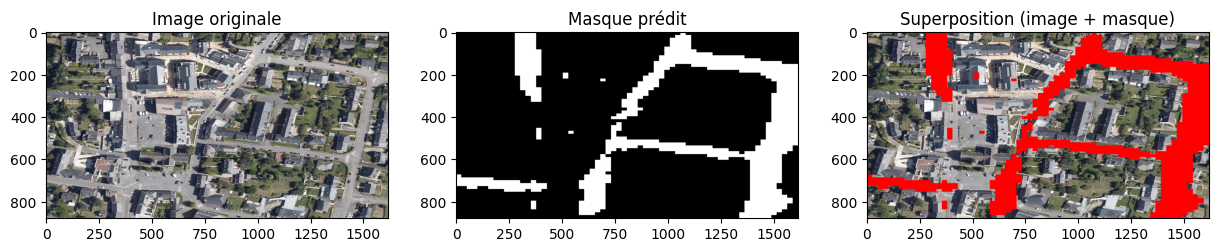

In [78]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


test_image_path = "/content/drive/MyDrive/Dataset/test_images/image_010.png"
image = Image.open(test_image_path).convert("RGB")
image_array = np.array(image)


with torch.no_grad():
    output = model(image_tensor)
    prediction = (torch.sigmoid(output) > 0.5).float().squeeze().cpu().numpy()


mask_array = (prediction * 255).astype(np.uint8)


if mask_array.shape != image_array.shape[:2]:
    mask_array = np.array(Image.fromarray(mask_array).resize(image.size, resample=Image.NEAREST))


overlay = image_array.copy()
overlay[mask_array > 0] = [255, 0, 0]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_array)
plt.title("Image originale")

plt.subplot(1, 3, 2)
plt.imshow(mask_array, cmap="gray")
plt.title("Masque prédit")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Superposition (image + masque)")

plt.show()